## Training demo for any model with custom loss function and SeismicDataLoader

In this demo, SeismicConvLSTM is used as the model and CustomLoss is used as the loss function.
- This demo uses train and validation dataloaders from dataloader.py. If you haven't seen dataloader_demo.ipynb, check it first.
- First, import train and validation dataloader
- Next, import custom loss function from customloss.py
- Next, we add SeismicConvLSTM model for demo purposes
- Next, import torch optimizer (we will use Adam, if you use other optimizers, import it)
- Then, we add matplotlib plt for traning, validation graph plotting
- Finally, add train_model function from trainer.py

In [1]:
from dataloader import train_dataloader, val_dataloader
from customLoss import CustomLoss
from convlstm import SeismicConvLSTM
import torch.optim as optim
import matplotlib.pyplot as plt
from trainer import train_model

---------------- Dataset information: ----------------
[I] Sample rate: 100 Hz
[I] Chosen window size:900
[I] Hopping size:300
[I] Each sample is window_size/sample rate seconds long. Each sample has 3 channels.
[I] Dataset values shape is: [num_samples, num_window, num_channel, (height) 1, (width) num_sample_points]
[I] Dataset value shape: torch.Size([1575, 3, 3, 1, 900])
[I] Dataset labels shape is: [num_samples, 4], where the 4 values are [p_idx, s_idx, p_confidence, s_confidence]
[I] Dataset label shape:torch.Size([4725, 4])
[I] One sample shape: torch.Size([3, 3, 1, 900])
[I] One label shape: torch.Size([4])
[I] An example sample's label: tensor([4.7900e+02, 1.0180e+03, 1.0000e+00, 0.0000e+00])
[I] ----------------------------------------------------
[I] First sample in the dataset:
[I] Data shape: torch.Size([3, 3, 1, 900])
[I] Label shape: torch.Size([4])
[I] Label: tensor([-1., -1.,  0.,  0.])
[S] --------------------------
Dataloaders are created.
[S] Train dataloader size:80

### Model setup

This below cell creates a model instance. If you'd like to use your own model, change this cell.
The example SeismicConvLSTM model takes the below inputs:
- input channel size
- output dimension
- numer of sequence windows
- data points in each window
- hidden dimensions of convlstm cells
- kernel size of conv layers
- number of convlstm cells

model variable is used to keep the model

In [2]:
# Define the model
# We are dynamically fetching the input channels, num_windows, data_points_of_each_window, and the output_dim from the dataset using the dataloader
one_sample = next(iter(train_dataloader)) # one_sample[0].shape, one_sample[1].shape --> torch.Size([16, 3, 3, 1, 900]) torch.Size([16, 4])
INPUT_CHANNELS = one_sample[0].shape[2] # one_sample[0].shape[2] --> 3
OUTPUT_DIM = one_sample[1].shape[1] # one_sample[1].shape[1] --> 4
NUM_WINDOWS = one_sample[0].shape[1] # one_sample[0].shape[1] --> 3
DATA_POINTS_OF_EACH_WINDOW = one_sample[0].shape[4] # one_sample[0].shape[4] --> 900
HIDDEN_DIM = [64, 64]
KERNEL_SIZE = (3, 3)   
NUM_CONVLSTM_BLOCKS = 2
assert len(HIDDEN_DIM) == NUM_CONVLSTM_BLOCKS, "The number of hidden dimensions should be equal to the number of ConvLSTM blocks"
model = SeismicConvLSTM(input_dim=INPUT_CHANNELS, hidden_dim=HIDDEN_DIM, kernel_size=KERNEL_SIZE, num_layers=NUM_CONVLSTM_BLOCKS, output_dim=OUTPUT_DIM, num_windows = NUM_WINDOWS, data_points = DATA_POINTS_OF_EACH_WINDOW)

print(model)

SeismicConvLSTM(
  (convlstm): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (convs): ModuleList(
          (0): Conv2d(67, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1-3): 3 x Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (1): ConvLSTMCell(
        (convs): ModuleList(
          (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1-3): 3 x Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
    )
  )
  (fc1): Linear(in_features=172800, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
)


### Training the model
We have been created dataloaders and model. Now we will train the model with generic train function.
- First, initialize optimizer. In this demo, Adam optimizer is used with lr = LEARNING_RATE.
- Next, set the loss function as criterion. In this demo, CustomLoss function with lambda_val = CUSTOM_LOSS_LAMBDA is used.
- Then, set the number of epochs.
- Next, train the model. train_model function trains the model with train_dataloader, and validates after each epoch with val_dataloader

In [3]:
LEARNING_RATE = 0.01
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

CUSTOM_LOSS_LAMBDA = 1
criterion = CustomLoss(lambda_val=CUSTOM_LOSS_LAMBDA)

num_epochs = 3

# Train the model with the training dataloader
model, train_losses, val_losses = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs)

Batch Loss: 382387.6875
Batch Loss: 69162.3281
Batch Loss: 4046856.2500
Batch Loss: 588663.3125
Batch Loss: 634277.8750
Epoch 0/2, Training Loss: 1157346.1987
Validation Loss: 674735.9760
Batch Loss: 399381.5000
Batch Loss: 583438.5625
Batch Loss: 549737.1250
Batch Loss: 119665.0859
Batch Loss: 282117.1250
Epoch 1/2, Training Loss: 389553.7965
Validation Loss: 94448.7629
Batch Loss: 121858.3516
Batch Loss: 50228.1016
Batch Loss: 38163.1172
Batch Loss: 115547.9844
Batch Loss: 157026.1719
Epoch 2/2, Training Loss: 95014.4523
Validation Loss: 159950.9976
Training complete


Model saved at:  models/model_20241003-1543_epoch3_lr0.01_lambda1_windows3_datapoints900.pth


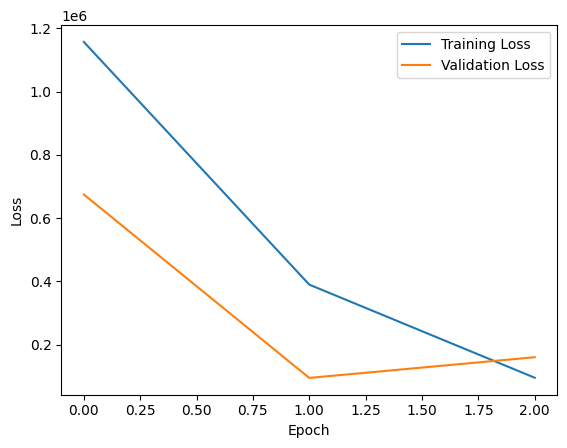

In [4]:
import os
import time
import torch

os.makedirs('models', exist_ok=True)
date_time_str = time.strftime("%Y%m%d-%H%M")
model_name = 'models/model_{}_epoch{}_lr{}_lambda{}_windows{}_datapoints{}.pth'.format(date_time_str, num_epochs, LEARNING_RATE, CUSTOM_LOSS_LAMBDA, NUM_WINDOWS, DATA_POINTS_OF_EACH_WINDOW)
torch.save(model.state_dict(), model_name)
print('Model saved at: ', model_name)

# plot and save the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('models/Train_and_val_loss_model_{}'.format(model_name.split('/')[1].split('.')[0]))
plt.show()